![alt text](path_to_banner_image.jpg)
# Title
Author: Elijah Lopez

## Overview


## Business Problem


## Data

### Imports

In [492]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Inferential Statistical Tests
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Helper Functions

In [493]:
"""
Helper Function to:
    Replace spaces with underscoress
    Make all columns lowercase
"""
def standardize_columns(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

In [494]:
def perform_anova(df, group_col, value_col, alpha):
    """
    Performs a one-way ANOVA test to compare means across groups.
    
    Parameters:
        df (pd.dfFrame) - The data containing the groups and values.
        group_col (str) - The column name representing the groups
        value_col (str) - The column name representing the values to compare
        alpha (float) - Confidence level
    
    Returns:
        dict: A dictionary containing the F-Statistic, P-Value, and interpretation
    """
    # Group the df by the specified group column
    grouped = df.groupby(group_col)[value_col]
    
    # Extract values for each group into separate lists
    grouped_values = [grouped.get_group(group).values for group in grouped.groups.keys()]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(*grouped_values)
    
    # Interpretation
    result = {
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Significance": "Reject the null in favor of the alterantive hypothesis."
        if p_value < 0.05 else "Fail to reject the null hypothesis."
    }
    
    return result

In [495]:
def perform_tukeys_hsd(df, group_col, value_col, alpha):
    """
    Perform Tukey's HSD test to determine significant differences between groups.

    Parameters:
        df (pd.DataFrame) - The data containing the groups and values.
        group_col (str) - The column representing groups (e.g., 'month').
        value_col (str) - he column representing the dependent variable (e.g., 'lead_count').
        alpha (float) - Confidence level

    Returns:
        results: Tukey HSD test results.
    """
    tukey = pairwise_tukeyhsd(
        endog=df[value_col],  # The dependent variable
        groups=df[group_col],  # The grouping variable
        alpha=alpha  # Significance level
    )
    print(tukey)
    return tukey


### Sources

In [496]:
# Leads
leads = pd.read_csv('data/location_1/leads.csv')
leads = standardize_columns(leads)

# # Accounts
accounts = pd.read_csv('data/location_1/accounts.csv')
accounts = standardize_columns(accounts)

# # Students
# students = pd.read_csv('data/location_1/students.csv')
# students = standardize_columns(students)

### Leads

In [497]:
# Inspect Contents
leads.head()

,created_date,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
0,10/11/2021,0,Mail Only,Unconverted,Female,7,Internet
1,2/14/2022,1,Assessed,Converted,NaN,NaN,Not Specified
2,10/19/2021,2,Assessed,Converted,NaN,NaN,Not Specified
3,2/6/2019,0,Open,Unconverted,NaN,NaN,Internet
4,7/28/2021,0,Contacted,Unconverted,Male,12,Location


In [498]:
# See shape of df
leads.shape

(1533, 7)

In [499]:
# Replace 0 for NaN in zipcodes
leads['zip_code'].replace(0, np.NaN, inplace=True)

In [500]:
# View Data Types
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   created_date       1533 non-null   object 
 1   zip_code           541 non-null    float64
 2   lead_status        1497 non-null   object 
 3   conversion_status  1533 non-null   object 
 4   student_gender     374 non-null    object 
 5   grade              806 non-null    object 
 6   lead_source        1533 non-null   object 
dtypes: float64(1), object(6)
memory usage: 84.0+ KB


In [501]:
# Count nulls -- Note: some still exist as non 'null' values
leads.isna().sum()

created_date            0
zip_code              992
lead_status            36
conversion_status       0
student_gender       1159
grade                 727
lead_source             0
dtype: int64

In [502]:
# Not very helpful for zipcodes
leads.describe()

,zip_code
count,541.000000
mean,7.517560
std,7.542114
min,1.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,42.000000


There are 1,533 leads with 7 features. The 

* created_date - Should be tranformed to datetime
* zip_code - Masked for anonyminity. 0 Represents null values.
* lead_status - 36 untracked leads
* conversion_status - No nulls
* student_gender - Most nulls (1,159), indicating this data is not collected consistently upon initial lead contact
* grade - 727 null values; 'college' and 'k' are forcing string type. Convert to integers.
* lead_source - Nulls represented as 'Not Specified'

In [503]:
# Transform created_date to datetime and make index
leads['created_date'] = pd.to_datetime(leads['created_date'])
leads.sort_values(by='created_date', ascending=True, inplace=True)
leads.set_index('created_date', inplace=True)

In [504]:
# Calculate date range of data
min_date = leads.index.min().strftime('%Y-%m-%d')
max_date = leads.index.max().strftime('%Y-%m-%d')
print(f'The data includes leads from {min_date} to {max_date}.')

The data includes leads from 2011-08-11 to 2024-12-09.


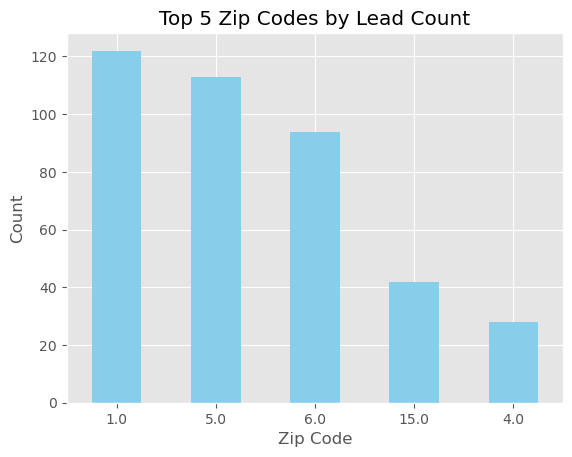

In [505]:
# Top 5 Zip Codes by Lead Volume
top_zip_codes_count = leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_count.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Lead Count')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

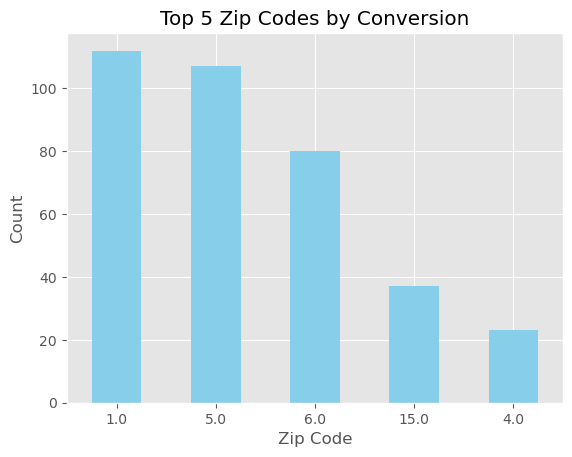

In [506]:
# Isolate Converted Leads
converted_leads = leads.loc[leads['conversion_status'] == 'Converted']

# Top 5 Zip Codes by Conversion
top_zip_codes_converted = converted_leads['zip_code'].value_counts().nlargest(5)

# Plot
top_zip_codes_converted.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Top 5 Zip Codes by Conversion')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show();

Zip Code Counts for converted leads is almost identical to the Zip Code Count for all Leads. This indicates that this information is likely captured after the enrollment, not during initial lead contact.

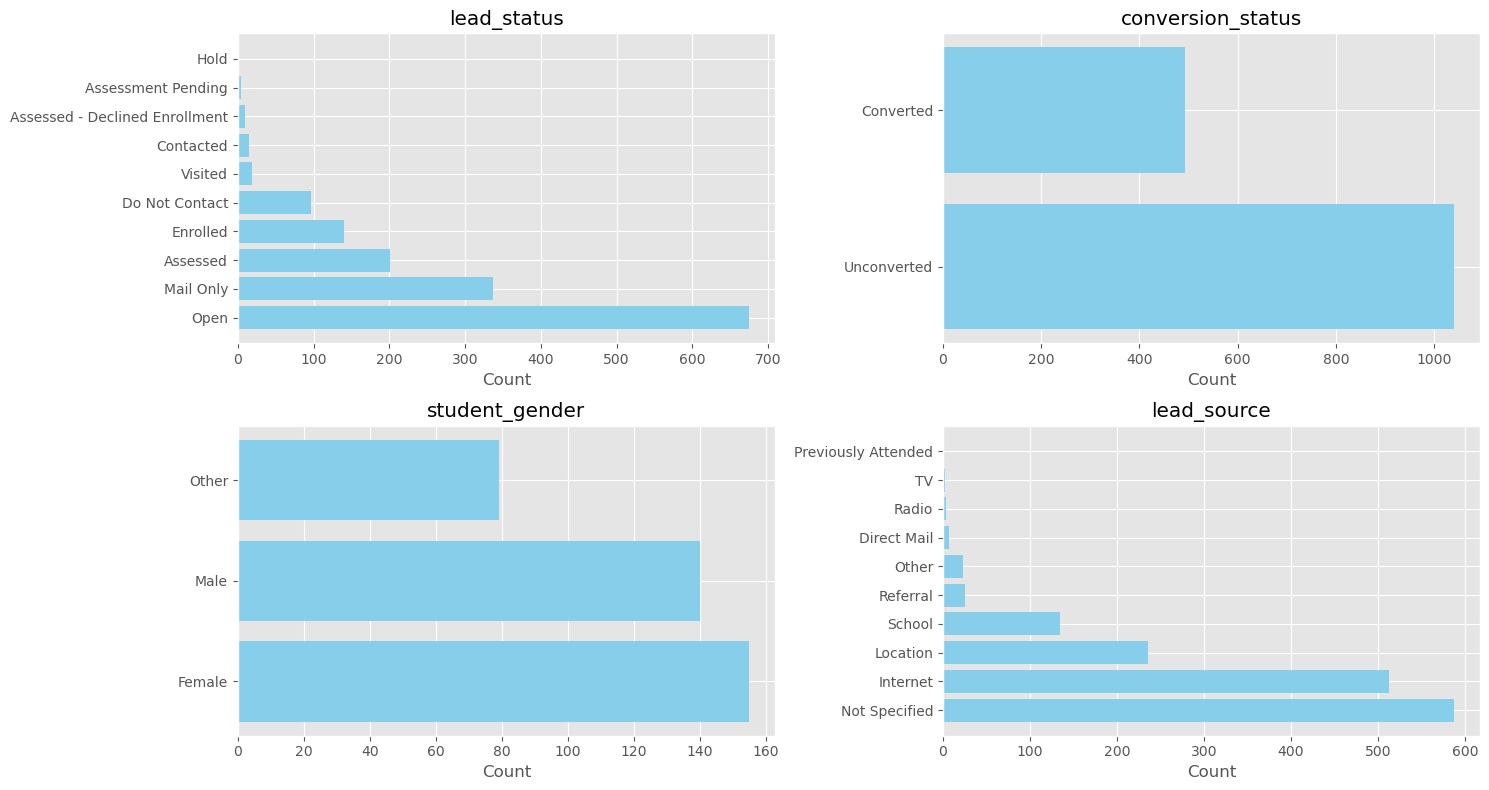

In [507]:
# Identify categorical columns
cat_cols = ['lead_status', 'conversion_status', 'student_gender', 'lead_source']

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

# Apply to each column
for i, column in enumerate(cat_cols):
    x = leads[column].value_counts().index
    y = leads[column].value_counts().values
    
    # Horizontal bar plots
    axes[i].barh(x, y, color='skyblue')
    
    # Add title and labels
    axes[i].set_title(column)
    axes[i].set_xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout();

In [508]:
# Calculate overall lead conversion
lead_conversion = len(leads.loc[leads['conversion_status'] == 'Converted']) / len(leads) * 100
print(f'Lead conversion: {lead_conversion:.0f}%')

Lead conversion: 32%


In [509]:
# Group leads by month
monthly_leads = leads['conversion_status'].resample('M').count()    # Use conversion_status because it has no nulls
monthly_leads.index = pd.to_datetime(monthly_leads.index)
monthly_leads

created_date
2011-08-31     1
2011-09-30     0
2011-10-31     0
2011-11-30     0
2011-12-31     0
              ..
2024-08-31    13
2024-09-30    25
2024-10-31    16
2024-11-30    19
2024-12-31     4
Freq: M, Name: conversion_status, Length: 161, dtype: int64

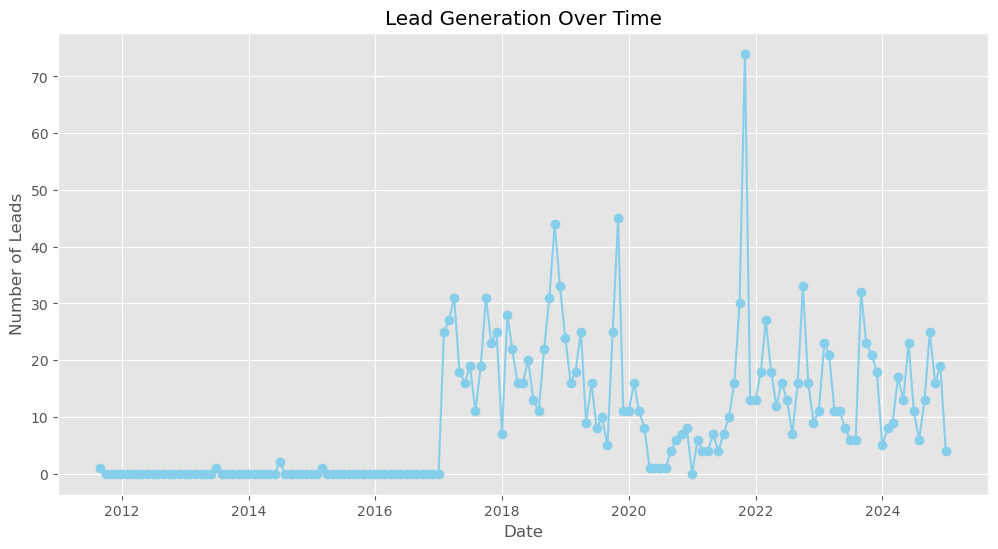

In [510]:
# Plot monthly leads over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_leads.index, monthly_leads.values, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Lead Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Leads')
plt.grid(True)
plt.show();

It looks like leads prior to 2017 were extremely low on a monthly basis. Let's focus on more recent years where the data is more consistent.

In [511]:
# Filter date >= 2017-01-01 and group by month
# Exclude Dec 2024 so that it doesn't throw off average since data only goes to 2024-12-09
filtered_monthly_leads = monthly_leads[(monthly_leads.index >= '2017-01-01') & (monthly_leads.index < '2024-12-01')]

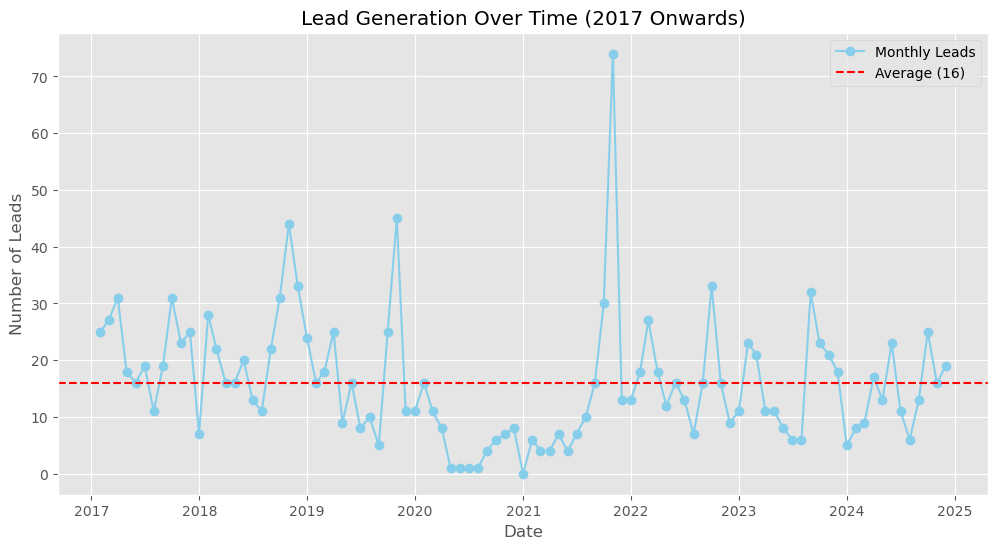

In [512]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(filtered_monthly_leads.index, filtered_monthly_leads.values, marker='o', linestyle='-', color='skyblue', label='Monthly Leads')

# Calculate and plot the mean
average_leads = filtered_monthly_leads.mean()
plt.axhline(y=average_leads, color='red', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title, labels, and legend
plt.title('Lead Generation Over Time (2017 Onwards)')
plt.xlabel('Date')
plt.ylabel('Number of Leads')
plt.legend()
plt.grid(True)
plt.show();

Next lets look at average lead volume per month

In [513]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_leads = filtered_monthly_leads.to_frame()
filtered_monthly_leads['month'] = filtered_monthly_leads.index.month_name().str[:3]
filtered_monthly_leads.rename(columns={'conversion_status': 'lead_count'}, inplace=True)

# Group by month and calculate the mean for each
monthly_mean = filtered_monthly_leads.groupby('month').mean()

monthly_mean

,lead_count
month,
Apr,10.875000
Aug,15.875000
Dec,10.142857
Feb,17.375000
Jan,17.500000
Jul,7.750000
Jun,9.750000
Mar,16.250000
May,13.000000


<Figure size 1000x600 with 0 Axes>

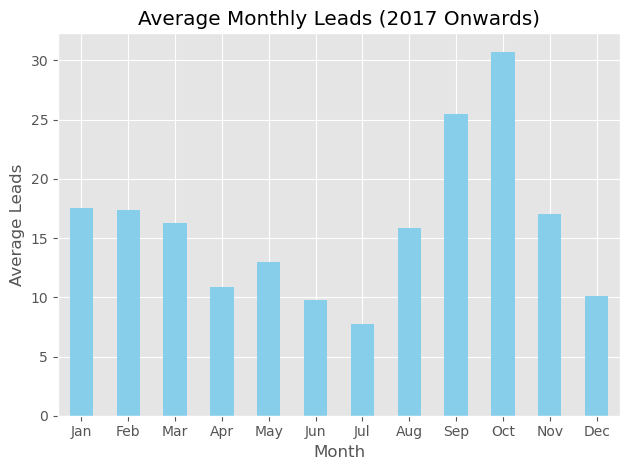

In [514]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_mean = monthly_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
monthly_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Monthly Leads (2017 Onwards)')
plt.xlabel('Month')
plt.ylabel('Average Leads')
plt.xticks(rotation=0)
plt.tight_layout();

These graphs show a cyclical pattern where lead interest peaks in October (roughly corresponding with the end of the 1st quarter) and dropping to its lowest during July (middle of summer).

#### ANOVA & Tukey's HSD

Because I am comparing multiple groups I will conduct an ANOVA test.
* H0: There is not a significant difference in lead volume for different months of the year.
* H1: There is a significant difference in lead volume for different months of the year.
* Alpha = 0.05

In [515]:
# Run ANOVA Test
perform_anova(filtered_monthly_leads, 'month', 'lead_count', 0.05)

{'F-Statistic': 3.7757495107575205,
 'P-Value': 0.00021142382968498226,
 'Significance': 'Reject the null in favor of the alterantive hypothesis.'}

In [516]:
# Follow up with Tukey's HSD
tukey_results = perform_tukeys_hsd(filtered_monthly_leads, 'month', 'lead_count', 0.05)
tukey_results

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   Apr    Aug      5.0 0.9964 -11.2599 21.2599  False
   Apr    Dec  -0.7321    1.0 -17.5627 16.0984  False
   Apr    Feb      6.5 0.9704  -9.7599 22.7599  False
   Apr    Jan    6.625  0.966  -9.6349 22.8849  False
   Apr    Jul   -3.125    1.0 -19.3849 13.1349  False
   Apr    Jun   -1.125    1.0 -17.3849 15.1349  False
   Apr    Mar    5.375 0.9933 -10.8849 21.6349  False
   Apr    May    2.125    1.0 -14.1349 18.3849  False
   Apr    Nov    6.125  0.981 -10.1349 22.3849  False
   Apr    Oct   19.875 0.0049   3.6151 36.1349   True
   Apr    Sep   14.625 0.1199  -1.6349 30.8849  False
   Aug    Dec  -5.7321 0.9915 -22.5627 11.0984  False
   Aug    Feb      1.5    1.0 -14.7599 17.7599  False
   Aug    Jan    1.625    1.0 -14.6349 17.8849  False
   Aug    Jul   -8.125 0.8718 -24.3849  8.1349  False
   Aug    Jun   -6.125  0.98

In [517]:
# Create data frame
tukey_df = pd.DataFrame(tukey_results.summary().data[1:])
tukey_data = tukey_results.summary().data[1:]
tukey_columns = tukey_results.summary().data[0]
tukey_df = pd.DataFrame(data=tukey_data, columns=tukey_columns)

# Isolate significant differences
tukey_df.loc[tukey_df['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
9,Apr,Oct,19.8750,0.0049,3.6151,36.1349,True
28,Dec,Oct,20.6071,0.0048,3.7766,37.4377,True
49,Jul,Oct,23.0000,0.0005,6.7401,39.2599,True
50,Jul,Sep,17.7500,0.0204,1.4901,34.0099,True
54,Jun,Oct,21.0000,0.0022,4.7401,37.2599,True
61,May,Oct,17.7500,0.0204,1.4901,34.0099,True


* October has significantly more leads than April, May, June, July, and December.
* September has significantly more leads than July. 
* All other months do not show a significant difference

#### Grade

Grade is updated every year to keep track of students over time. We'll have to calculate the grade at time of lead creation to make this useful. Because 'college' (13) is a fixed value, students with that label will be excluded from this calculation.

In [518]:
# Create map to replace 'College' and 'K'
grade_map = {
    'College': 13,
    'K': 0
}

In [519]:
# Replace
leads['grade'] = leads['grade'].replace(grade_map)

In [520]:
# Copy Leads df and isolate those where Grade is not NaN or 13
lead_student_grades = leads.copy()
lead_student_grades = lead_student_grades.loc[(lead_student_grades['grade'] != 13) & (lead_student_grades['grade'].notna())]

In [521]:
# Calculate elapsed time
lead_student_grades['elapsed_years'] = (pd.to_datetime('now') - lead_student_grades.index)

# Convert to years
lead_student_grades['elapsed_years'] = round(lead_student_grades['elapsed_years'].dt.total_seconds() / (60 * 60 * 24 * 365.25), 0)
lead_student_grades.head()

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source,elapsed_years
created_date,,,,,,,
2017-01-07,NaN,Assessed - Declined Enrollment,Unconverted,Other,5,Internet,8.0
2017-01-09,NaN,Assessed,Unconverted,Male,12,Internet,8.0
2017-01-10,NaN,Do Not Contact,Unconverted,Male,8,Internet,8.0
2017-01-16,NaN,Open,Unconverted,Other,5,Internet,8.0
2017-01-23,NaN,Mail Only,Unconverted,Other,5,Direct Mail,8.0


In [522]:
lead_student_grades['grade'] = lead_student_grades['grade'].astype(int)
lead_student_grades['grade_when_created'] = lead_student_grades['grade'] - lead_student_grades['elapsed_years']
lead_student_grades.head()

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source,elapsed_years,grade_when_created
created_date,,,,,,,,
2017-01-07,NaN,Assessed - Declined Enrollment,Unconverted,Other,5,Internet,8.0,-3.0
2017-01-09,NaN,Assessed,Unconverted,Male,12,Internet,8.0,4.0
2017-01-10,NaN,Do Not Contact,Unconverted,Male,8,Internet,8.0,0.0
2017-01-16,NaN,Open,Unconverted,Other,5,Internet,8.0,-3.0
2017-01-23,NaN,Mail Only,Unconverted,Other,5,Direct Mail,8.0,-3.0


In [523]:
lead_student_grades['grade_when_created'].value_counts()

grade_when_created
 5.0     100
 4.0      89
 3.0      83
 2.0      72
 6.0      62
 0.0      44
 7.0      43
 1.0      41
 8.0      41
 9.0      26
-3.0      18
 10.0     16
-1.0       8
 11.0      7
-2.0       6
 12.0      2
-4.0       1
Name: count, dtype: int64

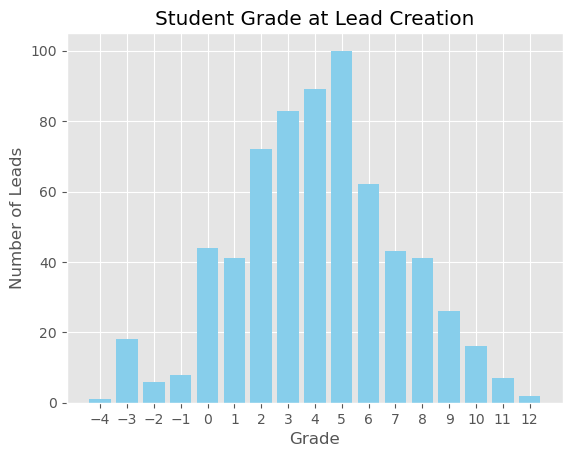

In [524]:
x = lead_student_grades['grade_when_created'].value_counts().index
y = lead_student_grades['grade_when_created'].value_counts().values

plt.bar(x, y, color='skyblue')

plt.title('Student Grade at Lead Creation')
plt.xlabel('Grade')
plt.xticks(range(int(x.min()), int(x.max()) + 1))
plt.ylabel('Number of Leads')

plt.show();

Here we see that some inquiries happen prior to Kindergarten, while most occur in 5th grade.

#### Lead Source

<BarContainer object of 1 artists>

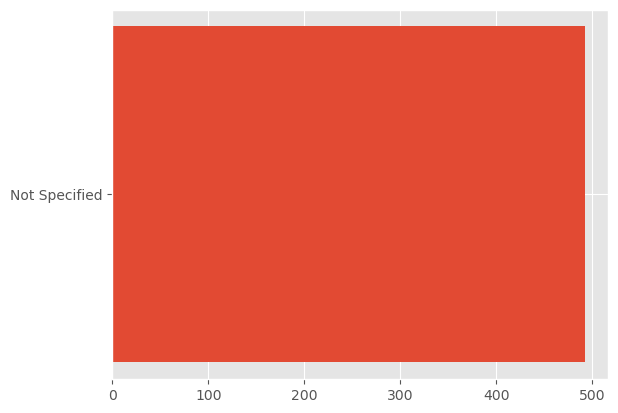

In [525]:
converted_leads['lead_source'].value_counts()
x = converted_leads['lead_source'].value_counts().index
y = converted_leads['lead_source'].value_counts().values

plt.barh(x, y)

This shows that all converted leads show lead source as null. This may be an issue with how the backend data is collected. I'll revisit this in accounts and see if I can resolve for deeper insights.

In [526]:
converted_leads.loc[converted_leads['lead_status'] != 'Enrolled']

,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
created_date,,,,,,
2011-08-11,1.0,Open,Converted,NaN,NaN,Not Specified
2014-06-05,10.0,Assessed,Converted,NaN,NaN,Not Specified
2017-01-07,1.0,Open,Converted,NaN,NaN,Not Specified
2017-02-04,NaN,Assessed,Converted,NaN,NaN,Not Specified
2017-06-30,15.0,Open,Converted,NaN,NaN,Not Specified
...,...,...,...,...,...,...
2023-09-21,20.0,Open,Converted,NaN,NaN,Not Specified
2023-10-12,5.0,Contacted,Converted,NaN,NaN,Not Specified
2023-10-19,32.0,Assessed,Converted,NaN,NaN,Not Specified


This shows a similar issue where not all converted accounts show an updated lead status of 'enrolled'. It could also indicate that these famiies were once enrolled but are not currently.

### Accounts

In [527]:
# Inspect contents
accounts.head()

,grade,status,membership_type,primary_enrollment_start,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
0,College,Inactive,Sessions Package,6/4/2018,7/6/2018,1 month,1 month,10,0
1,College,Inactive,Flexible,7/7/2018,9/1/2019,13.8 months,13.8 months,0,0
2,College,Inactive,Flexible,10/14/2019,3/31/2020,5.6 months,5.6 months,0,0
3,12,Inactive,Flexible,2/20/2020,6/2/2020,3.4 months,1.4 months,0,0
4,College,Inactive,Flexible,1/20/2017,2/24/2017,1.2 months,1.2 months,0,0


In [528]:
# See shape of df
accounts.shape

(653, 9)

In [529]:
# View Data Types
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   grade                       653 non-null    object
 1   status                      653 non-null    object
 2   membership_type             653 non-null    object
 3   primary_enrollment_start    653 non-null    object
 4   primary_enrollment_end      653 non-null    object
 5   enrollment_contract_length  653 non-null    object
 6   enrollment_length_of_stay   653 non-null    object
 7   total_sessions              653 non-null    int64 
 8   referral_account            653 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 46.0+ KB


In [530]:
# Check for nulls -- Thankfully, NONE!
accounts.isna().sum()

grade                         0
status                        0
membership_type               0
primary_enrollment_start      0
primary_enrollment_end        0
enrollment_contract_length    0
enrollment_length_of_stay     0
total_sessions                0
referral_account              0
dtype: int64

In [531]:
accounts.describe()

,total_sessions,referral_account
count,653.000000,653.000000
mean,4.251149,0.016845
std,11.167081,0.128790
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,8.000000,0.000000
max,99.000000,1.000000


In [532]:
accounts['membership_type'].value_counts()

membership_type
Flexible                                      412
Monthly Sessions                              129
Private Sessions Package                       39
Sessions Package                               35
Credits (Monthly Sessions)                     14
Summer Session Packages (Sessions Package)      9
Monthly Sessions (4x) (Monthly Sessions)        6
Summer 2024 (Private Sessions Package)          3
Summer Promotion (Sessions Package)             2
Unlimited Monthly Program (Flexible)            1
Summer Membership (Flexible)                    1
Enrollment Fee Only (Monthly Sessions)          1
Groupon (Sessions Package)                      1
Name: count, dtype: int64

In [533]:
accounts['total_sessions'].value_counts()

total_sessions
0     414
8     107
12     38
10     30
1      25
17     14
4      10
99      7
24      2
40      2
5       1
13      1
2       1
20      1
Name: count, dtype: int64

There are 653 listed accounts measured on 10 features.
* grade - Current grade; 'college' and 'k' are forcing string type. Convert to integers.
* status - Enrolled or inactive
* membership_type - Remove 'credits' and consolidate remaining
* primary_enrollment_start - Convert to datetime
* primary_enrollment_end - Convert to datetime
* enrollment_contract_length - Remove unit from entry. Convert to integers.
* enrollment_length_of_stay - Remove unit from entry. Convert to integers.
* total_sessions - Allowable sessions based on enrollment type, NOT total attended
* referral_account - 1 = yes, 0 = no

In [534]:
# Replace 'college' with 13 and 'k' with 0
accounts['grade'] = accounts['grade'].replace(grade_map)

In [535]:
# Remove 'credit' type enrollments from data frame
accounts = accounts[accounts['membership_type'] != 'Credits (Monthly Sessions)']

In [536]:
# Convert enrollment dates to date time
accounts['primary_enrollment_start'] = pd.to_datetime(accounts['primary_enrollment_start'])
accounts['primary_enrollment_end'] = pd.to_datetime(accounts['primary_enrollment_end'])

# Set index to enrollment start date and sort by date
accounts.set_index('primary_enrollment_start', inplace=True)
accounts.sort_index(ascending=True, inplace=True)

In [537]:
# Strip enrollment_contract_length & enrollment_length_of_stay of the word 'months'
accounts['enrollment_contract_length'] = accounts['enrollment_contract_length'].str.split(' ').str[0]
accounts['enrollment_length_of_stay'] = accounts['enrollment_length_of_stay'].str.split(' ').str[0]

In [538]:
accounts['membership_type'].value_counts()

membership_type
Flexible                                      412
Monthly Sessions                              129
Private Sessions Package                       39
Sessions Package                               35
Summer Session Packages (Sessions Package)      9
Monthly Sessions (4x) (Monthly Sessions)        6
Summer 2024 (Private Sessions Package)          3
Summer Promotion (Sessions Package)             2
Groupon (Sessions Package)                      1
Enrollment Fee Only (Monthly Sessions)          1
Unlimited Monthly Program (Flexible)            1
Summer Membership (Flexible)                    1
Name: count, dtype: int64

In [539]:
# Create map for various membership types
def map_program_type(program_type):
    if 'Fee' in program_type:
        return 'Other'
    elif 'Flexible' in program_type:
        return 'Flexible'
    elif 'Monthly' in program_type:
        return 'Monthly Sessions'
    elif 'Private' in program_type:
        return 'Private Sessions'
    elif 'Sessions' in program_type:
        return 'Session Packages'
    else:
        return 'Other'

In [540]:
# Apply mapping to membership_type
accounts['membership_type'] = accounts['membership_type'].apply(map_program_type)
membership_type_counts = accounts['membership_type'].value_counts()
membership_type_counts

membership_type
Flexible            414
Monthly Sessions    135
Session Packages     47
Private Sessions     42
Other                 1
Name: count, dtype: int64

In [541]:
# Percentage of recurring enrollment types
percent_recurring_enrollments = (membership_type_counts['Flexible'] + membership_type_counts['Monthly Sessions']) / membership_type_counts.sum() * 100
print(f'The percentage of enrollments that choose a recurring program is: {percent_recurring_enrollments:.0f}%')

The percentage of enrollments that choose a recurring program is: 86%


In [542]:
accounts.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
primary_enrollment_start,,,,,,,,
2013-06-28,13,Inactive,Flexible,2014-08-31,14.1,14.1,0,0
2014-07-17,13,Inactive,Flexible,2015-04-30,9.4,9.4,0,0
2015-02-22,13,Inactive,Flexible,2016-01-31,11.3,11.3,0,0
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0


In [543]:
print(accounts['membership_type'].unique())  # Check unique values to see what we have


['Flexible' 'Session Packages' 'Private Sessions' 'Monthly Sessions'
 'Other']


In [544]:
place_holder = accounts['membership_type'] == 'Monthly Sessions'
accounts.loc[place_holder, 'membership_type'] = accounts.loc[place_holder, 'total_sessions'].astype(str) + 'x'

In [545]:
accounts.head()

,grade,status,membership_type,primary_enrollment_end,enrollment_contract_length,enrollment_length_of_stay,total_sessions,referral_account
primary_enrollment_start,,,,,,,,
2013-06-28,13,Inactive,Flexible,2014-08-31,14.1,14.1,0,0
2014-07-17,13,Inactive,Flexible,2015-04-30,9.4,9.4,0,0
2015-02-22,13,Inactive,Flexible,2016-01-31,11.3,11.3,0,0
2015-03-11,11,Inactive,Flexible,2016-03-31,12.7,12.7,0,0
2016-02-01,11,Inactive,Flexible,2016-03-31,1.9,1.9,0,0


In [546]:
accounts['membership_type'].value_counts()

membership_type
Flexible            414
8x                   94
Session Packages     47
Private Sessions     42
12x                  31
4x                   10
Other                 1
Name: count, dtype: int64

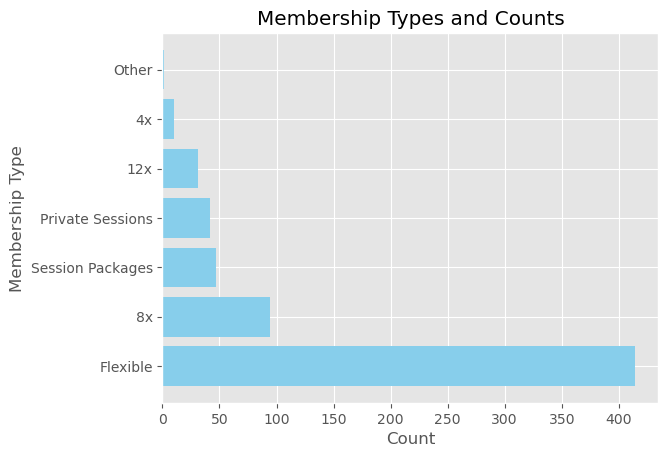

In [547]:
x = accounts['membership_type'].value_counts().index
y = accounts['membership_type'].value_counts().values

plt.barh(x, y, color='skyblue')

plt.title('Membership Types and Counts');
plt.xlabel('Count')
plt.ylabel('Membership Type')
plt.show();

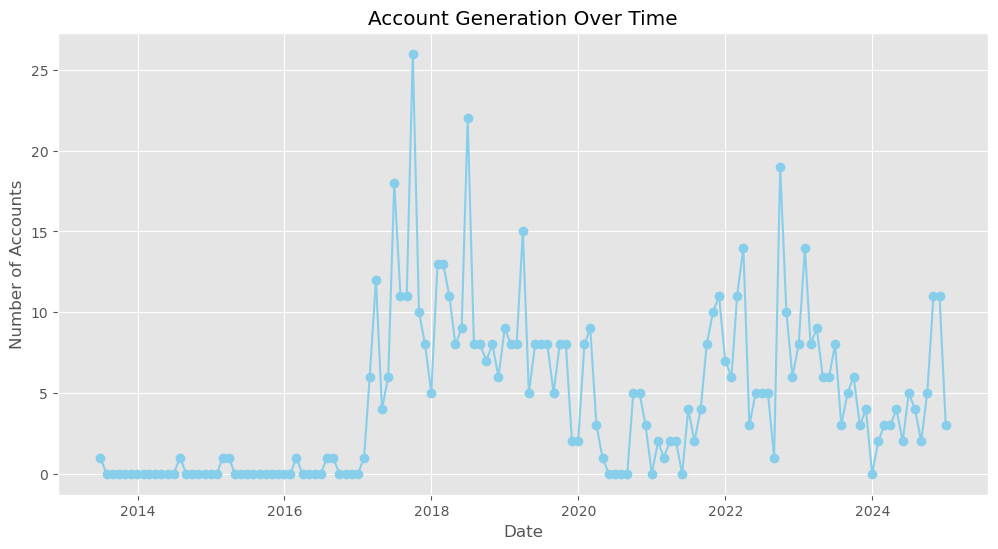

In [548]:
# Group enrollments by month
monthly_accounts = accounts['membership_type'].resample('M').count()    # Use membership_type because it has no nulls
monthly_accounts.index = pd.to_datetime(monthly_accounts.index)
monthly_accounts

# Plot monthly enrollments over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_accounts.index, monthly_accounts.values, marker='o', linestyle='-', color='skyblue')

# Add title and labels
plt.title('Account Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accounts')
plt.grid(True)
plt.show();

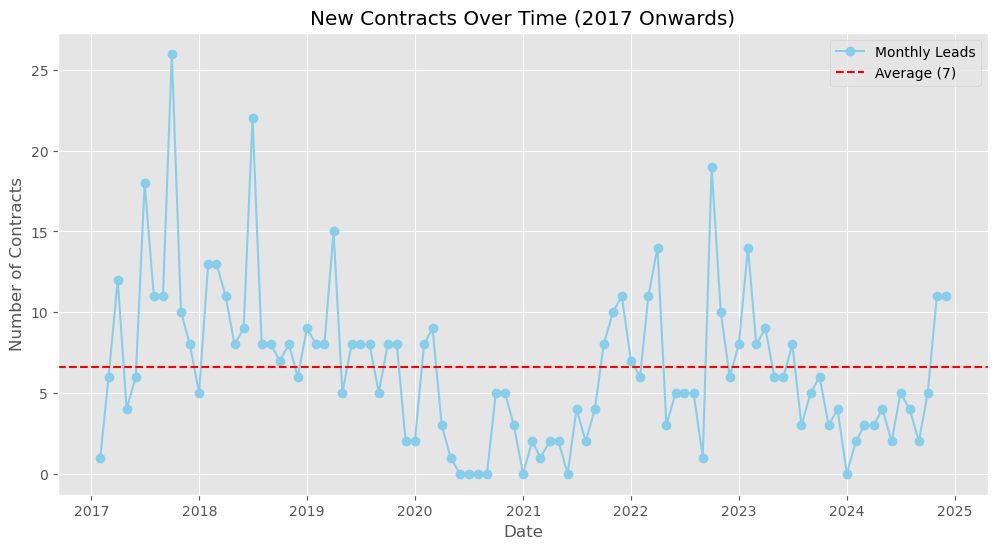

In [549]:
# Filter date >= 2017-01-01 and group by month
filtered_monthly_accounts_start = monthly_accounts[(monthly_accounts.index >= '2017-01-01') & (monthly_accounts.index < '2024-12-01')]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(filtered_monthly_accounts_start.index, filtered_monthly_accounts_start.values, marker='o', linestyle='-', color='skyblue', label='Monthly Leads')

# Calculate and plot the mean
average_leads = filtered_monthly_accounts_start.mean()
plt.axhline(y=average_leads, color='red', linestyle='--', label=f'Average ({average_leads:.0f})')

# Add title, labels, and legend
plt.title('New Contracts Over Time (2017 Onwards)')
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.legend()
plt.grid(True)
plt.show();

Note: This data includes students that re-enroll and siblings recorded under the same lead account so direct comparison to lead chart above will not match overall Lead Conversion.

New Enrollment Agreements by Month Start

In [550]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_accounts_start = filtered_monthly_accounts_start.to_frame()
filtered_monthly_accounts_start['month'] = filtered_monthly_accounts_start.index.month_name().str[:3]
filtered_monthly_accounts_start.rename(columns={'membership_type': 'enrollments'}, inplace=True)

# Group by month and calculate the mean for each
enrollment_mean = filtered_monthly_accounts_start.groupby('month').mean()
enrollment_mean

,enrollments
month,
Apr,4.125000
Aug,4.500000
Dec,4.428571
Feb,7.375000
Jan,6.750000
Jul,5.125000
Jun,8.750000
Mar,8.625000
May,4.500000


<Figure size 1000x600 with 0 Axes>

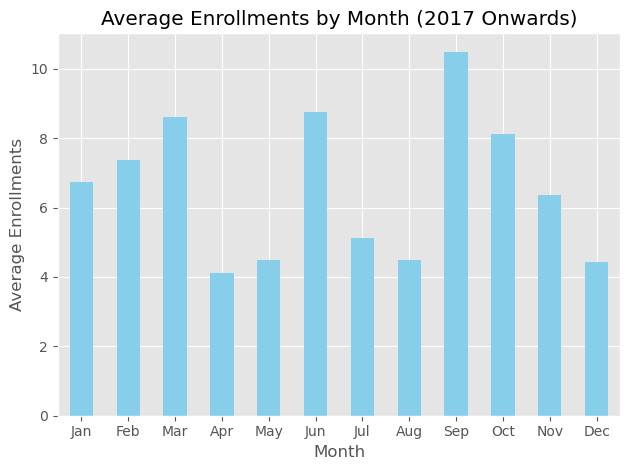

In [551]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
enrollment_mean = enrollment_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
enrollment_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Enrollments by Month (2017 Onwards)')
plt.xlabel('Month')
plt.ylabel('Average Enrollments')
plt.xticks(rotation=0)
plt.tight_layout();

Enrollment End Dates by Month

In [552]:
accounts_end = accounts.copy()
accounts_end.set_index('primary_enrollment_end', inplace=True)
# Filter date >= 2017-01-01 and group by month
filtered_accounts_end = accounts_end[(accounts_end.index >= '2017-01-01') & (accounts_end.index < '2024-12-01')]
filtered_monthly_accounts_end = filtered_accounts_end['membership_type'].resample('M').count()    # Use membership_type because it has no nulls
filtered_monthly_accounts_end.index = pd.to_datetime(filtered_monthly_accounts_end.index)
filtered_monthly_accounts_end.head()


primary_enrollment_end
2017-02-28    1
2017-03-31    1
2017-04-30    2
2017-05-31    1
2017-06-30    7
Freq: M, Name: membership_type, dtype: int64

In [553]:
# Create a 'month' column and set equal to 3 letter abbreviation
filtered_monthly_accounts_end = filtered_monthly_accounts_end.to_frame()
filtered_monthly_accounts_end['month'] = filtered_monthly_accounts_end.index.month_name().str[:3]
filtered_monthly_accounts_end.rename(columns={'membership_type': 'cancelations'}, inplace=True)

# Group by month and calculate the mean for each
cancelation_mean = filtered_monthly_accounts_end.groupby('month').mean()
cancelation_mean

,cancelations
month,
Apr,6.500000
Aug,12.625000
Dec,5.000000
Feb,4.625000
Jan,7.571429
Jul,7.125000
Jun,4.875000
Mar,5.500000
May,6.750000


<Figure size 1000x600 with 0 Axes>

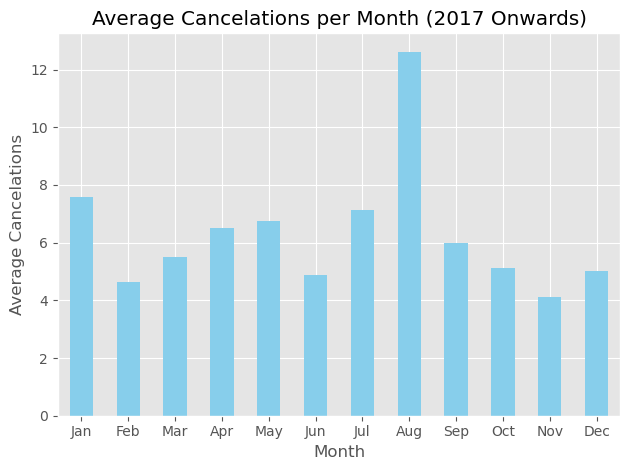

In [554]:
# Sort by the month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
cancelation_mean = cancelation_mean.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
cancelation_mean.plot(kind='bar', color='skyblue', legend=False)

# Add title and labels
plt.title('Average Cancelations per Month (2017 Onwards)')
plt.xlabel('Month')
plt.ylabel('Average Cancelations')
plt.xticks(rotation=0)
plt.tight_layout();

In [555]:
enrollment_mean

,enrollments
month,
Jan,6.750000
Feb,7.375000
Mar,8.625000
Apr,4.125000
May,4.500000
Jun,8.750000
Jul,5.125000
Aug,4.500000
Sep,10.500000


In [556]:
cancelation_mean

,cancelations
month,
Jan,7.571429
Feb,4.625000
Mar,5.500000
Apr,6.500000
May,6.750000
Jun,4.875000
Jul,7.125000
Aug,12.625000
Sep,6.000000


In [557]:
net_monthly_change = enrollment_mean['enrollments'] - cancelation_mean['cancelations']
net_monthly_change

month
Jan   -0.821429
Feb    2.750000
Mar    3.125000
Apr   -2.375000
May   -2.250000
Jun    3.875000
Jul   -2.000000
Aug   -8.125000
Sep    4.500000
Oct    3.000000
Nov    2.250000
Dec   -0.571429
dtype: float64

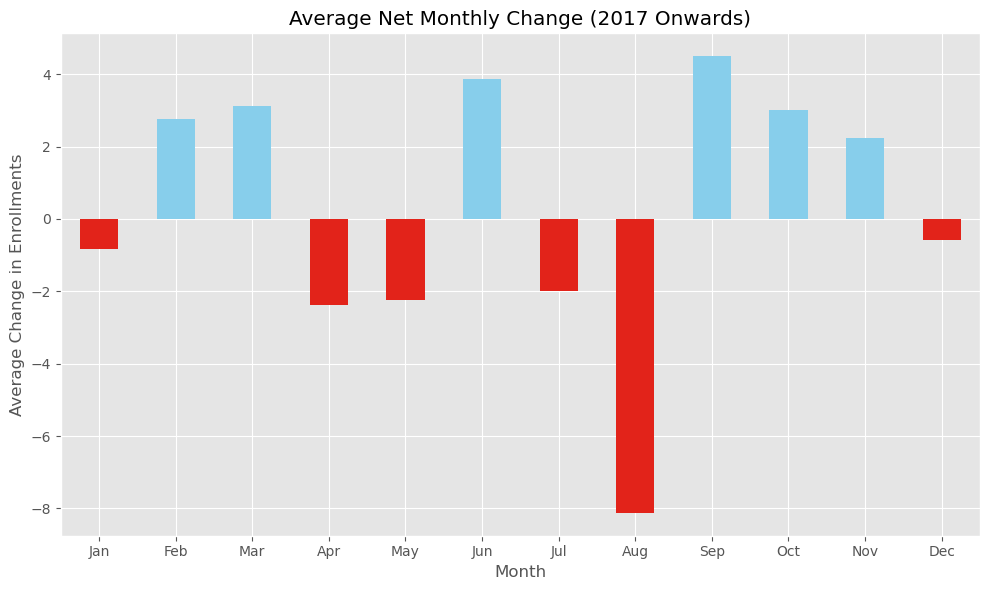

In [561]:
# Plot
plt.figure(figsize=(10, 6))
colors = ['#E2231A' if value < 0 else 'skyblue' for value in net_monthly_change]
net_monthly_change.plot(kind='bar', color=colors, legend=False)

# Add title and labels
plt.title('Average Net Monthly Change (2017 Onwards)')
plt.xlabel('Month')
plt.ylabel('Average Change in Enrollments')
plt.xticks(rotation=0)
plt.tight_layout();

In [558]:
stop

NameError: name 'stop' is not defined

___

### Encoding

In [ ]:
leads.columns

Index(['created_date', 'zip_code', 'lead_status', 'conversion_status',
       'student_gender', 'grade', 'lead_source'],
      dtype='object')

#### Lead Status

In [ ]:
leads['lead_status'].value_counts().index

Index(['Open', 'Mail Only', 'Assessed', 'Enrolled', 'Do Not Contact',
       'Visited', 'Contacted', 'Assessed - Declined Enrollment',
       'Assessment Pending', 'Hold'],
      dtype='object', name='lead_status')

In [ ]:
lead_status_map = {
    'Open': 1,
    'Contacted': 2,
    'Visited': 3,
    'Assessment Pending': 4,
    'Assessed': 5,
    'Assessed - Declined Enrollment': 6,
    'Enrolled': 7,
    'Hold': 8,
    'Mail Only': 9,
    'Do Not Contact': 10,
}

In [ ]:
leads['lead_status'] = leads['lead_status'].replace(lead_status_map)

#### Conversion Status

In [ ]:
leads['conversion_status'].value_counts().index

Index(['Unconverted', 'Converted'], dtype='object', name='conversion_status')

In [ ]:
conversion_status_map = {
    'Unconverted': 0,
    'Converted': 1
}

In [ ]:
leads['conversion_status'] = leads['conversion_status'].replace(conversion_status_map)

#### Student Gender

In [ ]:
leads['student_gender'].value_counts().index

Index(['Female', 'Male', 'Other'], dtype='object', name='student_gender')

In [ ]:
student_gender_map = {
    'Other': 0,
    'Female': 1,
    'Male': 2
}

In [ ]:
leads['student_gender'] = leads['student_gender'].replace(student_gender_map)

#### Lead Source

In [ ]:
leads['lead_source'].value_counts().index

Index(['Not Specified', 'Internet', 'Location', 'School', 'Referral', 'Other',
       'Direct Mail', 'Radio', 'TV', 'Previously Attended'],
      dtype='object', name='lead_source')

In [ ]:
lead_source_map = {
    'Not Specified': 0,
    'Previously Attended': 1,
    'Referral': 2,
    'Location': 3,
    'School': 4,
    'Events': 5,
    'Print': 6,                  # 'Media (Print, TV, Radio)'
    'TV': 6,
    'Radio': 6,
    'Direct Mail': 7,
    'Internet': 8,
    '3rd Party Site': 9,
    'Other': 10
}

In [ ]:
leads['lead_source'] = leads['lead_source'].replace(lead_source_map)

In [ ]:
# Check
leads.dtypes

created_date         datetime64[ns]
zip_code                    float64
lead_status                 float64
conversion_status             int64
student_gender              float64
grade                        object
lead_source                   int64
dtype: object

In [ ]:
leads.corr()

,created_date,zip_code,lead_status,conversion_status,student_gender,grade,lead_source
created_date,1.000000,-0.102737,0.084457,-0.147050,0.259243,-0.401972,0.057571
zip_code,-0.102737,1.000000,-0.084823,0.008635,0.149141,-0.191069,0.014757
lead_status,0.084457,-0.084823,1.000000,-0.147757,0.293650,0.081753,0.116195
conversion_status,-0.147050,0.008635,-0.147757,1.000000,NaN,NaN,-0.732464
student_gender,0.259243,0.149141,0.293650,NaN,1.000000,0.056376,-0.063242
grade,-0.401972,-0.191069,0.081753,NaN,0.056376,1.000000,0.024218
lead_source,0.057571,0.014757,0.116195,-0.732464,-0.063242,0.024218,1.000000


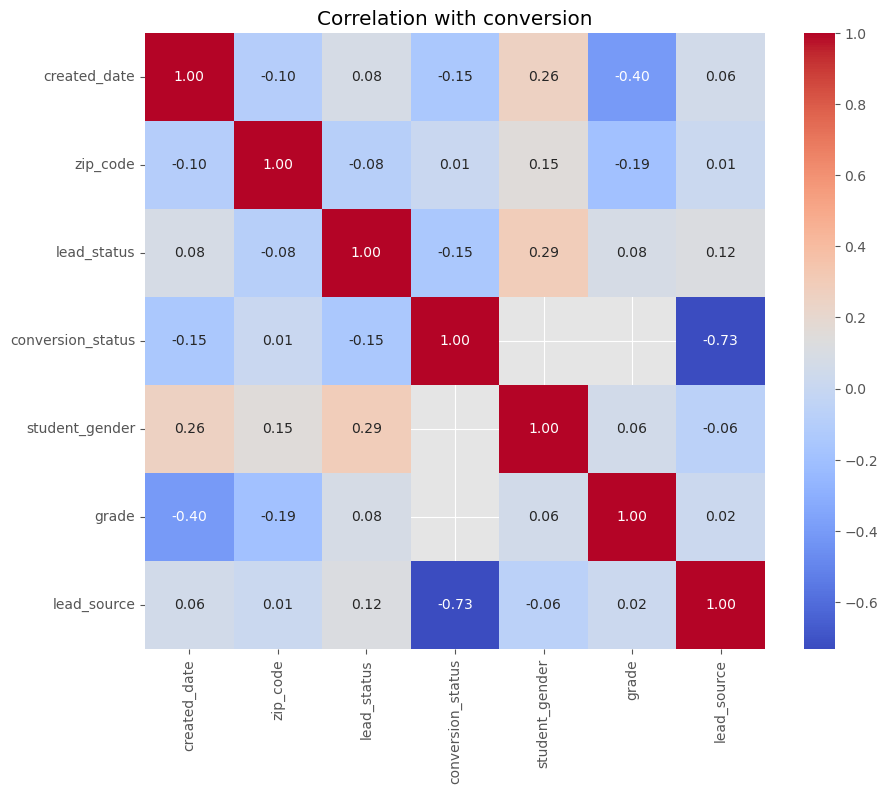

In [ ]:
# Calculate correlation matrix
correlation_matrix = leads.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(leads.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation with conversion')
plt.show()


### Summary of Data Findings

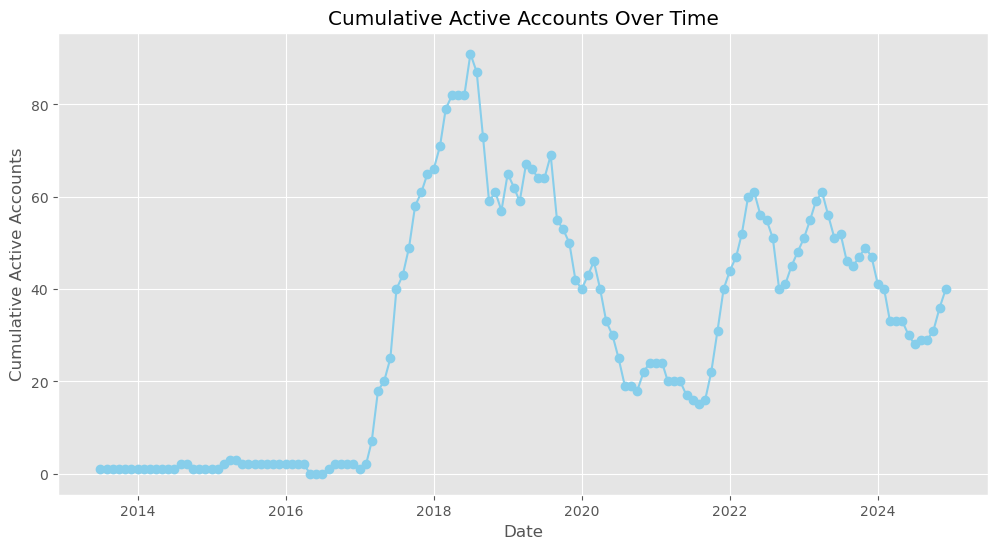

In [ ]:
# Generate a date range for all months in the data
date_range = pd.date_range(
    start=accounts.index.min(), 
    end=accounts.index.max(), 
    freq='M'
)

# Create an empty DataFrame to hold cumulative counts
cumulative_enrollments = pd.DataFrame(index=date_range, columns=['active_accounts'])
cumulative_enrollments['active_accounts'] = 0  # Initialize with zeros

# Calculate cumulative enrollments for each month
for date in date_range:
    cumulative_enrollments.loc[date, 'active_accounts'] = accounts[
        (date >= accounts.index) & 
        ((date <= accounts['primary_enrollment_end']) | (accounts['primary_enrollment_end'].isna()))
    ].shape[0]

# Plot the cumulative enrollments
plt.figure(figsize=(12, 6))
plt.plot(cumulative_enrollments.index, cumulative_enrollments['active_accounts'], marker='o', color='skyblue')
plt.title('Cumulative Active Accounts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Active Accounts')
plt.grid(True)
plt.show()


# Come Back Later

## Potential Routes of Analysis


## Chosen Metrics for Analysis


## Data Cleaning & Feature Engineering

## Analysis

### Direction 1


#### Direction 1 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 1:

### Direction 2


#### Direction 2 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 2:

### Direction 3

#### Direction 3 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 3:

## Results


### Direction 1
* 


### Direction 2
* 


### Direction 3
* 

## Conclusions
This analysis leads to three recommendations.

1. 

2. 

3. 

## Next Steps
* 